In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/Usuario/Downloads/olist_consolidated_dataset.csv")

In [3]:
df = df.drop_duplicates()

In [4]:
date_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp'
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [5]:
df = df.dropna(subset=['order_id', 'customer_id'])

In [6]:
num_cols_fill0 = ['price', 'freight_value', 'payment_installments', 'payment_value']
df[num_cols_fill0] = df[num_cols_fill0].fillna(0)


In [7]:
text_cols_fill = ['product_category_name', 'product_category_name_english',
                  'seller_city', 'seller_state', 'customer_city', 'customer_state']
df[text_cols_fill] = df[text_cols_fill].fillna('unknown')

In [8]:
coord_cols = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
df[coord_cols] = df[coord_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=coord_cols)

In [9]:
df = df.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'
})

In [10]:
df['cantidad'] = 1  

In [11]:
columnas_numericas = df.select_dtypes(include=np.number).columns.tolist()
variables_exogenas = [col for col in columnas_numericas if col != 'cantidad']


In [12]:
dias_venta = df.groupby('product_category_name_english')['order_purchase_timestamp'].apply(
    lambda x: pd.to_datetime(x).dt.date.nunique()
).reset_index(name='dias_venta')

In [14]:
productos_mas_45_dias = dias_venta[dias_venta['dias_venta'] > 45]

In [15]:
productos_mas_45_dias

,product_category_name_english,dias_venta
0,agro_industry_and_commerce,144
1,air_conditioning,198
2,art,153
4,audio,234
5,auto,582
6,baby,561
7,bed_bath_table,598
8,books_general_interest,306
9,books_imported,51
10,books_technical,172


In [ ]:
resultado_final = df[df['product_category_name_english'].isin(
    productos_mas_45_dias['product_category_name_english']
)].groupby(
    ['product_category_name_english', pd.to_datetime(df['order_purchase_timestamp']).dt.date]
).agg(
    {'cantidad': 'sum', **{var: 'mean' for var in variables_exogenas}}
).reset_index()

In [18]:
resultado_final.columns = [
    'categoria_producto', 
    'fecha_venta', 
    'total_ventas', 
    *[f'promedio_{var}' for var in variables_exogenas]
]
resultado_final

,categoria_producto,fecha_venta,total_ventas,promedio_order_item_id,promedio_price,promedio_freight_value,promedio_product_name_length,promedio_product_description_length,promedio_product_photos_qty,promedio_product_weight_g,...,promedio_seller_zip_code_prefix,promedio_customer_zip_code_prefix,promedio_payment_sequential,promedio_payment_installments,promedio_payment_value,promedio_review_score,promedio_customer_lat,promedio_customer_lng,promedio_seller_lat,promedio_seller_lng
0,agro_industry_and_commerce,2017-01-23,2,1.5,21.990000,8.720000,35.000000,380.000000,1.0,125.000000,...,3569.000000,5409.000000,1.000000,1.0,61.420000,4.000000,-23.555477,-46.675485,-23.541942,-46.490955
1,agro_industry_and_commerce,2017-01-31,1,1.0,21.990000,24.350000,35.000000,380.000000,1.0,125.000000,...,3569.000000,64058.000000,1.000000,4.0,46.340000,5.000000,-5.059366,-42.753682,-23.541942,-46.490955
2,agro_industry_and_commerce,2017-02-05,1,1.0,21.990000,14.520000,35.000000,380.000000,1.0,125.000000,...,3569.000000,32223.000000,1.000000,1.0,36.510000,3.000000,-19.961706,-44.035239,-23.541942,-46.490955
3,agro_industry_and_commerce,2017-02-08,1,1.0,21.990000,17.780000,35.000000,380.000000,1.0,125.000000,...,3569.000000,74922.000000,1.000000,1.0,39.770000,3.000000,-16.759650,-49.225962,-23.541942,-46.490955
4,agro_industry_and_commerce,2017-02-12,1,1.0,92.900000,20.970000,40.000000,628.000000,1.0,2650.000000,...,86990.000000,79006.000000,1.000000,1.0,113.870000,4.000000,-20.479710,-54.640387,-23.489938,-51.788819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18625,watches_gifts,2018-08-25,3,1.0,129.850000,13.883333,49.333333,888.666667,2.0,386.000000,...,11043.666667,36340.333333,1.000000,7.0,143.733333,3.666667,-23.106464,-48.193875,-22.676466,-47.111788
18626,watches_gifts,2018-08-26,2,1.5,93.000000,7.910000,58.000000,737.000000,3.0,350.000000,...,5849.000000,2407.000000,1.000000,1.0,201.820000,4.000000,-23.485360,-46.624284,-23.651115,-46.755211
18627,watches_gifts,2018-08-27,3,1.0,48.666667,7.600000,59.333333,452.666667,3.0,283.333333,...,5849.000000,14248.000000,1.333333,1.0,37.400000,5.000000,-23.492057,-47.302976,-23.651115,-46.755211
18628,watches_gifts,2018-08-28,1,1.0,59.000000,7.670000,54.000000,257.000000,5.0,200.000000,...,5849.000000,4538.000000,1.000000,1.0,66.670000,5.000000,-23.587027,-46.680540,-23.651115,-46.755211


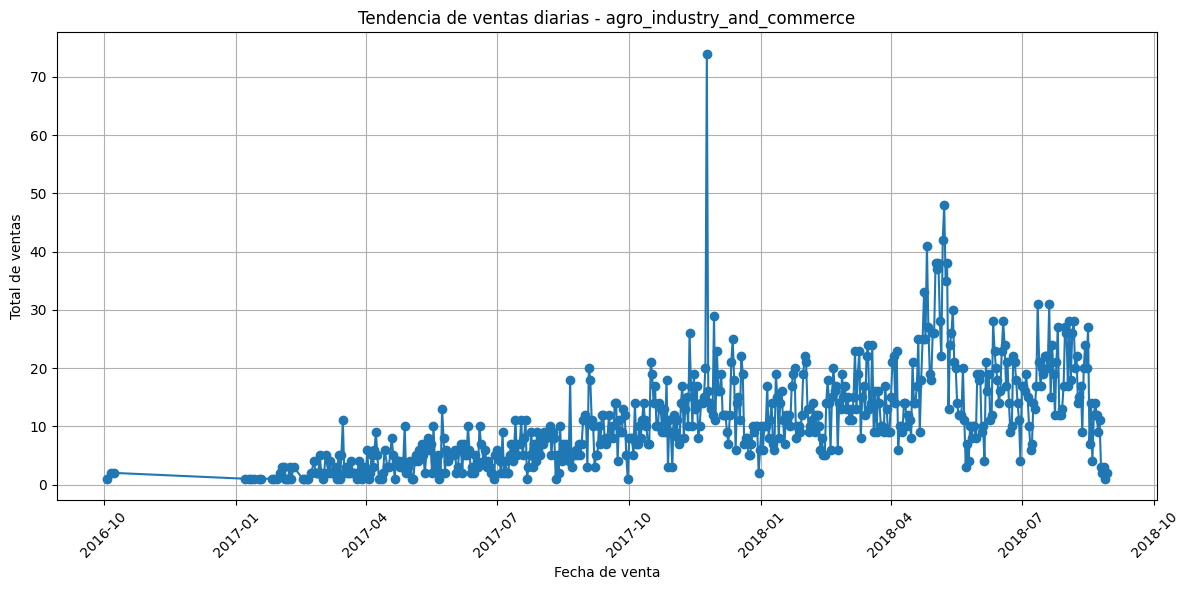

In [24]:
df_categoria = resultado_final[resultado_final['categoria_producto'] == 'watches_gifts']


plt.figure(figsize=(12,6))
plt.plot(df_categoria['fecha_venta'], df_categoria['total_ventas'], marker='o')
plt.title(f"Tendencia de ventas diarias - {categoria_ejemplo}")
plt.xlabel("Fecha de venta")
plt.ylabel("Total de ventas")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

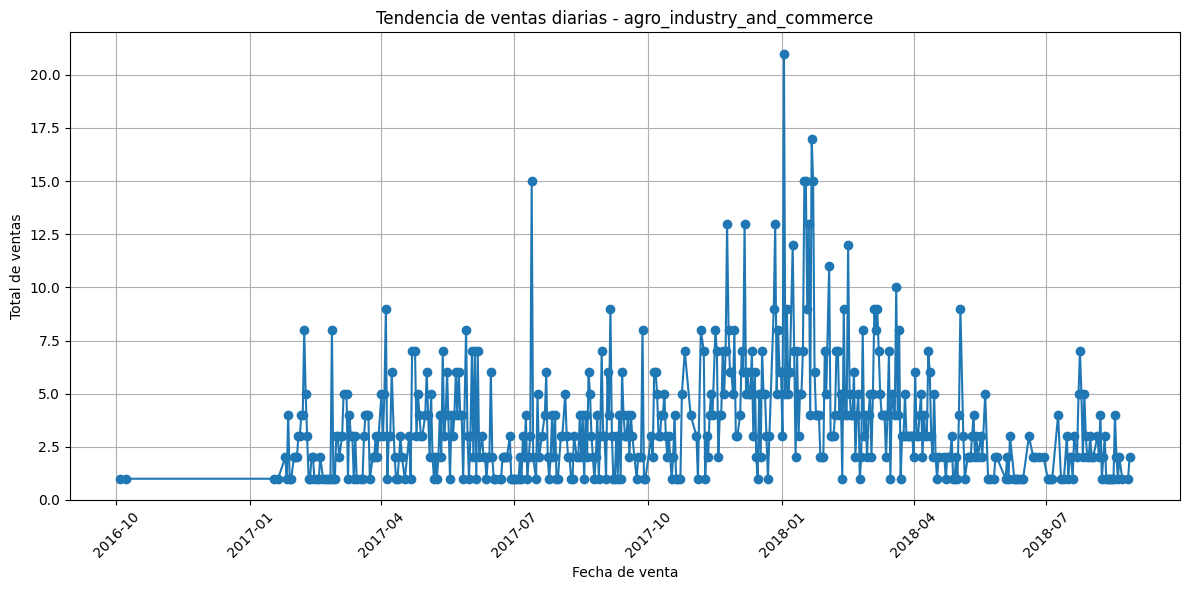

In [25]:
df_categoria = resultado_final[resultado_final['categoria_producto'] == 'unknown']


plt.figure(figsize=(12,6))
plt.plot(df_categoria['fecha_venta'], df_categoria['total_ventas'], marker='o')
plt.title(f"Tendencia de ventas diarias - {categoria_ejemplo}")
plt.xlabel("Fecha de venta")
plt.ylabel("Total de ventas")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()